### (MPI) Maximum Probability of Improvement Acquisition

In [1]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np
import pandas as pd
from pyomo.environ import *
from GPy.kern import RBF
from GPy.kern import Matern52
from GPy.kern import Linear
from datetime import datetime
import time
import os
import textwrap
import re
import inspect
import matplotlib.pyplot as plt

In [2]:
start_time = datetime.fromtimestamp(time.time())

data_path = r'DataSet\siouxdata\\'

candid = pd.read_excel(data_path + 'candidpoint.xlsx', sheet_name='Sheet1')
deltalink = pd.read_excel(data_path + 'deltalinksioux.xlsx', sheet_name='Sheet1')
facilitycap = pd.read_excel(data_path + 'capfacsioux.xlsx', sheet_name='Sheet1')
nodedem = pd.read_excel(data_path + 'demandsioux.xlsx', sheet_name='Sheet1')
linkcap = pd.read_excel(data_path + 'caplinknsioux.xlsx', sheet_name='Sheet1')
linkfreecost = pd.read_excel(data_path + 'freeflownsioux.xlsx', sheet_name='Sheet1')
qod = pd.read_excel(data_path + 'xodsioux.xlsx', sheet_name='Sheet1')   
numod = pd.read_excel(data_path + 'numodsioux.xlsx', sheet_name='Sheet1')
deltaod = pd.read_excel(data_path + 'deltaodsioux.xlsx', sheet_name='Sheet1')
fixedfacility = pd.read_excel(data_path + 'fixedcostsioux.xlsx', sheet_name='Sheet1')
capincreas=0.1 * pd.read_excel(data_path + 'caplinknsioux.xlsx', sheet_name='Sheet1')

end_time = datetime.fromtimestamp(time.time())

# --- Stop conditions
# max_time  = 1000
max_iter  = 150
# tolerance = 0 #1e-2

print('Total time for read data: ', end_time - start_time)

Total time for read data:  0:00:09.740485


In [3]:
[numlink,numpath]=np.shape(deltalink)
(a,numfacility)=np.shape(facilitycap)
(b,numcustomer)=np.shape(nodedem)
# sets
Model.setpath = range(numpath)
Model.setfacility = range(numfacility)
Model.setcustomer = range(numcustomer)
Model.setlink = range(numlink)
print('numpath', numpath, '\nnumlink: ', numlink, '\nnumfacility: ', numfacility)

numpath 940 
numlink:  100 
numfacility:  12


In [4]:
def objfunc2d(x):
    
    Model = AbstractModel()
    xe=np.zeros(([1,numlink]))
    y=np.zeros(([1,numfacility]))
    for k in Model.setlink:
        xe[0,k]=x[:,k]
            
    print(xe)
    Model._fprimrsk = Var(Model.setpath,within=NonNegativeReals)
    Model._ve = Var(Model.setlink,within=NonNegativeReals)
    
    def fobjective(Model):
        return sum(linkfreecost.iloc[0,e]*(Model._ve[e]+0.15*Model._ve[e]**5/
                                               (5*((linkcap.iloc[0,e]+xe[0,e]*capincreas.iloc[0,e])**4))) for e in Model.setlink)
    Model.obj = Objective(rule=fobjective,sense=minimize)

    def cons4(Model,r,s):
        return sum(Model._fprimrsk[k]*deltaod.iloc[numod.iloc[r,s]-1,k]  for k in Model.setpath)==qod.iloc[r,s]
    Model.con4 = Constraint(Model.setcustomer,Model.setcustomer,rule=cons4)
 
    def cons5(Model,e):
        return sum((Model._fprimrsk[k])*deltalink.iloc[e,k]  for k in Model.setpath) ==Model._ve[e]
    Model.con5=Constraint(Model.setlink,rule=cons5) 
        
    NTA0 = Model.create_instance()
    
    opt = SolverFactory('ipopt')
    opt.solve(NTA0)
    return sum(linkfreecost.iloc[0,e]*(1*NTA0._ve[e].value+0.15*NTA0._ve[e].value**5/
                                               (((linkcap.iloc[0,e]+xe[0,e]*capincreas.iloc[0,e])**4))) for e in Model.setlink)

## Here define constraints into function

In [5]:
def constraint_to_string(constraint_function):
    source_code = inspect.getsource(constraint_function)    
    source_code = textwrap.dedent(source_code)    
    constraint_expression = re.search(r'return\s+(.*)(\s)*$', source_code, re.MULTILINE).group(1)    
    return constraint_expression

bounds = [{'name': 'xe', 'type': 'discrete', 'domain': (0,1), 'dimensionality':numlink}]

## RBF kernel 35

In [6]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 35

constraint_string = constraint_to_string(budget_constraint)
constraints35 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [7]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints35) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)
s_kernel=RBF(input_dim=100)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(kernel=s_kernel, exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of (MPI) acquisition
acquisition = GPyOpt.acquisitions.MPI.AcquisitionMPI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf35 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization
bo_rbf35.run_optimization(max_iter=max_iter, verbosity=False) 

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 35 edges: ', end_time - start_time)

[[1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
  1. 0. 0. 0.]]
[[1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 1.]]
[[0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.
  0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 1.]]
[[0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.

[[0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
  1. 0. 1. 0.]]
[[0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.
  1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0.]]
[[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.

[[0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
  0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0.]]
[[1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 0.]]
[[0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 0. 0. 1.]]
[[0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.
  0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
  0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 1. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.

[[0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.
  0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 1.]]
[[0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
  0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.
  0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
  1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.
  1. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.

[[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0.
  1. 0. 0. 0.]]
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
  1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 1. 0.]]
[[0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
  1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
  0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  1. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0.

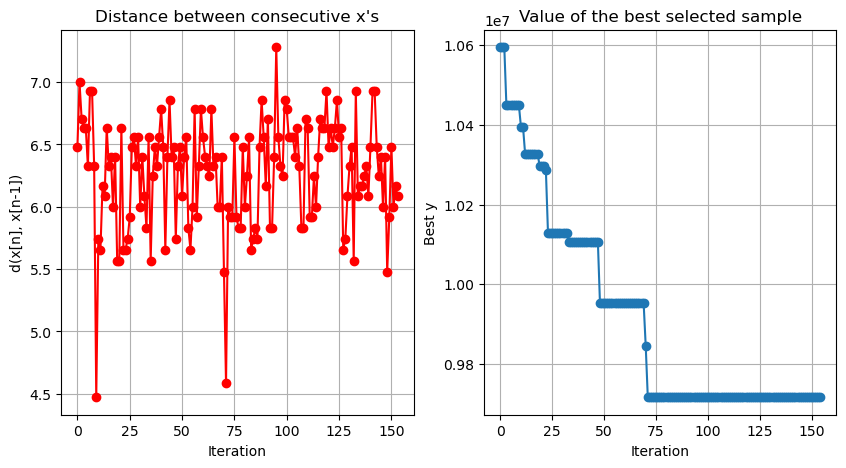

In [8]:
bo_rbf35.plot_convergence()

In [9]:
print(bo_rbf35.x_opt)
print(bo_rbf35.fx_opt)
bo_rbf35.Y_best

[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 0.]
9716521.086765118


array([10594805.34459478, 10594805.34459478, 10594805.34459478,
       10450081.81792207, 10450081.81792207, 10450081.81792207,
       10450081.81792207, 10450081.81792207, 10450081.81792207,
       10450081.81792207, 10395221.77829419, 10395221.77829419,
       10327771.96067884, 10327771.96067884, 10327771.96067884,
       10327771.96067884, 10327771.96067884, 10327771.96067884,
       10327771.96067884, 10297008.88867367, 10297008.88867367,
       10297008.88867367, 10285609.29972076, 10129571.37825645,
       10129571.37825645, 10129571.37825645, 10129571.37825645,
       10129571.37825645, 10129571.37825645, 10129571.37825645,
       10129571.37825645, 10129571.37825645, 10129571.37825645,
       10106337.2820136 , 10106337.2820136 , 10106337.2820136 ,
       10106337.2820136 , 10106337.2820136 , 10106337.2820136 ,
       10106337.2820136 , 10106337.2820136 , 10106337.2820136 ,
       10106337.2820136 , 10106337.2820136 , 10106337.2820136 ,
       10106337.2820136 , 10106337.28201

## RBF kernel 40

In [7]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 40

constraint_string = constraint_to_string(budget_constraint)
constraints40 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [8]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints40) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)
s_kernel=RBF(input_dim=100)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(kernel=s_kernel, exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of (MPI) acquisition
acquisition = GPyOpt.acquisitions.MPI.AcquisitionMPI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf40 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization
bo_rbf40.run_optimization(max_iter=max_iter, verbosity=False)

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 40 edges: ', end_time - start_time)

[[0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.
  1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  1. 1. 1. 1.]]
[[0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
  0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1.]]
[[0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
  1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.

[[1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
  0. 1. 1. 0.]]
[[1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
  1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 1. 1.]]
[[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
  0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
  0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
  0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  1. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
  1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.
  1. 1. 0. 0.]]
[[0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0.]]
[[0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.

[[1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.
  1. 1. 0. 1.]]
[[0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
  1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
  1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  1. 1. 1. 0.]]
[[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  1. 1. 1. 0.]]
[[0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.

[[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
  0. 1. 1. 1.]]
[[0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.
  0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.
  0. 1. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.

[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
  0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
  0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  1. 1. 0. 0.]]
[[0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0.
  1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
  0. 1. 0. 0.]]
[[0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.

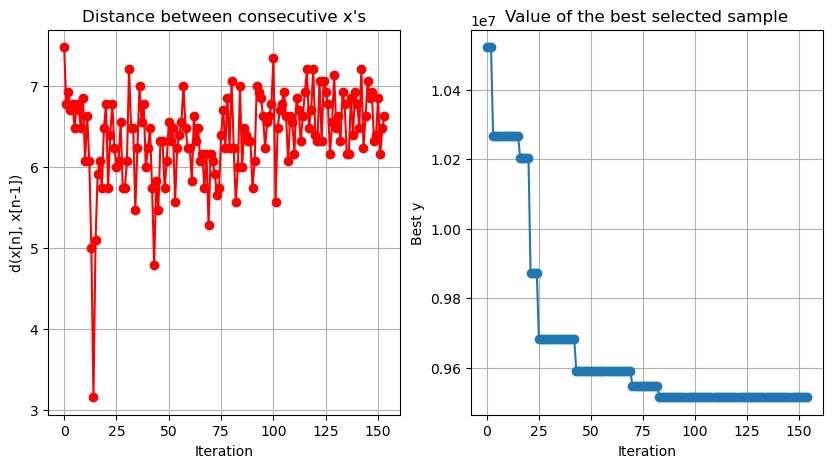

In [9]:
bo_rbf40.plot_convergence()

In [10]:
print(bo_rbf40.x_opt)
print(bo_rbf40.fx_opt)
bo_rbf40.Y_best

[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0.]
9515646.208169954


array([10521805.11992422, 10521805.11992422, 10521805.11992422,
       10265632.57925201, 10265632.57925201, 10265632.57925201,
       10265632.57925201, 10265632.57925201, 10265632.57925201,
       10265632.57925201, 10265632.57925201, 10265632.57925201,
       10265632.57925201, 10265632.57925201, 10265632.57925201,
       10265632.57925201, 10204537.36249593, 10204537.36249593,
       10204537.36249593, 10204537.36249593, 10204537.36249593,
        9871997.10801957,  9871997.10801957,  9871997.10801957,
        9871997.10801957,  9683417.5474469 ,  9683417.5474469 ,
        9683417.5474469 ,  9683417.5474469 ,  9683417.5474469 ,
        9683417.5474469 ,  9683417.5474469 ,  9683417.5474469 ,
        9683417.5474469 ,  9683417.5474469 ,  9683417.5474469 ,
        9683417.5474469 ,  9683417.5474469 ,  9683417.5474469 ,
        9683417.5474469 ,  9683417.5474469 ,  9683417.5474469 ,
        9683417.5474469 ,  9591222.72539321,  9591222.72539321,
        9591222.72539321,  9591222.72539

## RBF kernel 45

In [14]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 45

constraint_string = constraint_to_string(budget_constraint)
constraints45 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [15]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints45) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)
s_kernel=RBF(input_dim=100)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(kernel=s_kernel, exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of (MPI) acquisition
acquisition = GPyOpt.acquisitions.MPI.AcquisitionMPI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_rbf45 = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# Run the optimization
bo_rbf45.run_optimization(max_iter=max_iter, verbosity=False) 

end_time = datetime.fromtimestamp(time.time())
print('Total time for rbf kernel 45 edges: ', end_time - start_time)

[[0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
  1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.
  1. 0. 0. 1.]]
[[0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
  1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
  1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
  1. 1. 1. 0.]]
[[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
  0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0.
  0. 0. 1. 0.]]
[[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.

[[1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
  0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
  1. 0. 0. 1.]]
[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0.
  1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
  1. 1. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.

[[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
  1. 1. 1. 0.]]
[[0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1.
  0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.
  1. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1.
  0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.
  1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0.]]
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.

[[1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.
  1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 1.]]
[[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
  0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
  0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
  1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.
  0. 1. 0. 0.]]
[[1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1.
  0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1.
  0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.
  1. 1. 1. 0.]]
[[1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.

[[1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
  1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
  1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
  1. 1. 1. 1.]]
[[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
  1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
  1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.
  1. 0. 1. 0.]]
[[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
  0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0.
  0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1.
  0. 1. 1. 0.]]
[[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.

[[0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0.
  0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
  1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1.
  1. 1. 0. 0.]]
[[1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
  0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.
  0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  1. 0. 0. 1.]]
[[0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
  1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 1.]]
[[0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.

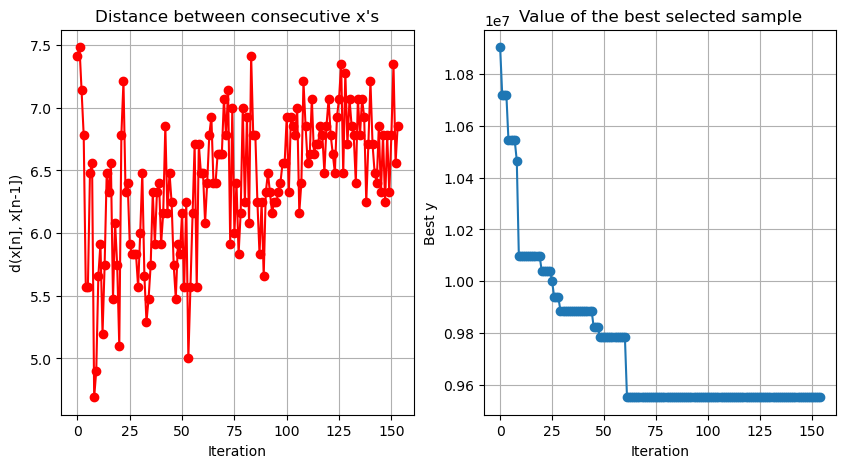

In [16]:
bo_rbf45.plot_convergence()

In [17]:
print(bo_rbf45.x_opt)
print(bo_rbf45.fx_opt)
bo_rbf45.Y_best

[1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 0.]
9552419.101062506


array([10903626.69721652, 10719683.42775518, 10719683.42775518,
       10719683.42775518, 10544456.36338768, 10544456.36338768,
       10544456.36338768, 10544456.36338768, 10465854.68615476,
       10096405.08277866, 10096405.08277866, 10096405.08277866,
       10096405.08277866, 10096405.08277866, 10096405.08277866,
       10096405.08277866, 10096405.08277866, 10096405.08277866,
       10096405.08277866, 10096405.08277866, 10040423.14704914,
       10040423.14704914, 10040423.14704914, 10040423.14704914,
       10040423.14704914,  9999302.51684652,  9937794.29693248,
        9937794.29693248,  9937794.29693248,  9885812.24333109,
        9885812.24333109,  9885812.24333109,  9885812.24333109,
        9885812.24333109,  9885812.24333109,  9885812.24333109,
        9885812.24333109,  9885812.24333109,  9885812.24333109,
        9885812.24333109,  9885812.24333109,  9885812.24333109,
        9885812.24333109,  9885812.24333109,  9885812.24333109,
        9821681.12594027,  9821681.12594

## Figure

In [14]:
print("Bayesian optimization function, (MPI) Acquisition for 35 = ", bo_rbf35.fx_opt,
      "\nBayesian optimization function, (MPI) Acquisition for 40 = ", bo_rbf40.fx_opt,
      "\nBayesian optimization function, (MPI) Acquisition for 45 = ", bo_rbf45.fx_opt)

Bayesian optimization function, (MPI) Acquisition for 35 =  9716521.08 
Bayesian optimization function, (MPI) Acquisition for 40 =  9515646.2 
Bayesian optimization function, (MPI) Acquisition for 45 =  9552419.1


In [19]:
bayesian_optimization = [bo_rbf35.fx_opt, bo_rbf40.fx_opt, bo_rbf45.fx_opt]
colors = ['red', 'blue', 'green']
selected_edges = [35, 40, 45]

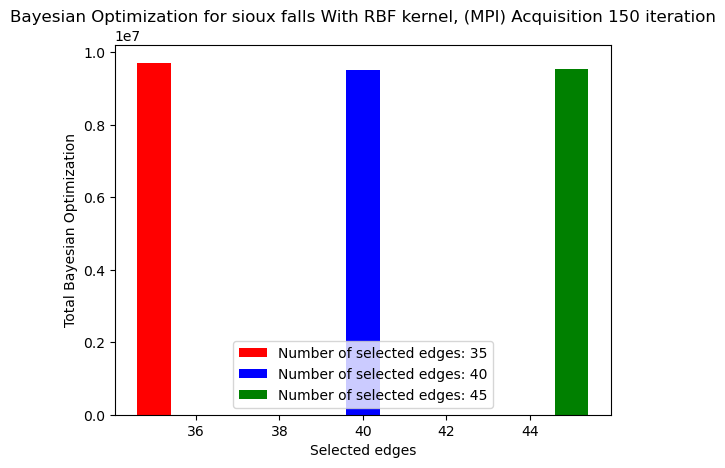

In [16]:
import matplotlib.pyplot as plt

for i, (edges, bo_value) in enumerate(zip(selected_edges, bayesian_optimization)):
    plt.bar(edges, bo_value, color=colors[i], label=f'Number of selected edges: {edges}')
    
plt.xlabel('Selected edges')
plt.ylabel('Total Bayesian Optimization')
plt.title('Bayesian Optimization for sioux falls With RBF kernel, (MPI) Acquisition 150 iteration')
plt.legend()
plt.show()

In [21]:
# Function to extract the convergence data from GPyOpt
def extract_convergence_data(bo):
    return bo.Y_best

# Extract convergence data
convergence_rbf_35 = extract_convergence_data(bo_rbf35)
convergence_rbf_40 = extract_convergence_data(bo_rbf40)
convergence_rbf_45 = extract_convergence_data(bo_rbf45)

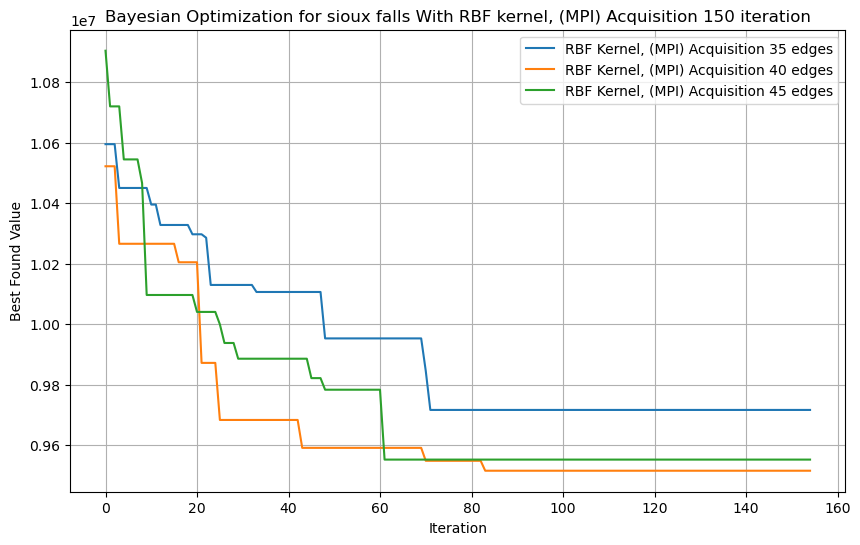

In [17]:
# Plot convergence data
plt.figure(figsize=(10, 6))
plt.plot(bo_rbf35.Y_best, label='RBF Kernel, (MPI) Acquisition 35 edges')
plt.plot(bo_rbf40.Y_best, label='RBF Kernel, (MPI) Acquisition 40 edges')
plt.plot(bo_rbf45.Y_best, label='RBF Kernel, (MPI) Acquisition 45 edges')

plt.xlabel('Iteration')
plt.ylabel('Best Found Value')
plt.title('Bayesian Optimization for sioux falls With RBF kernel, (MPI) Acquisition 150 iteration')
plt.legend(loc='best')
plt.grid(True)
plt.show()

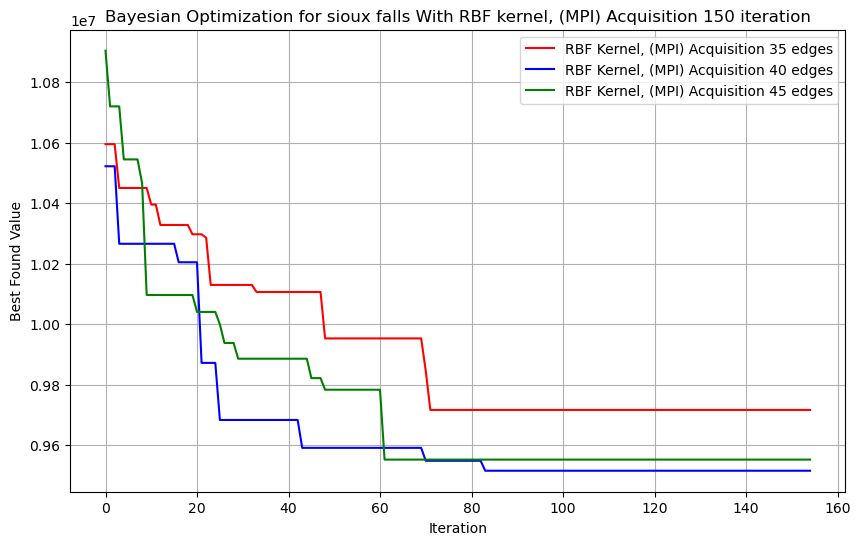

In [18]:
# Plot convergence data
plt.figure(figsize=(10, 6))
plt.plot(bo_rbf35.Y_best, color='red', label='RBF Kernel, (MPI) Acquisition 35 edges')
plt.plot(bo_rbf40.Y_best, color='blue', label='RBF Kernel, (MPI) Acquisition 40 edges')
plt.plot(bo_rbf45.Y_best, color='green', label='RBF Kernel, (MPI) Acquisition 45 edges')

plt.xlabel('Iteration')
plt.ylabel('Best Found Value')
plt.title('Bayesian Optimization for sioux falls With RBF kernel, (MPI) Acquisition 150 iteration')
plt.legend(loc='best')
plt.grid(True)
plt.show()